In [7]:
# importig the necessary libraries and the dataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

data = pd.read_csv('D:/QVI/QVI_data.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264834 entries, 0 to 264833
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   LYLTY_CARD_NBR    264834 non-null  int64  
 1   DATE              264834 non-null  object 
 2   STORE_NBR         264834 non-null  int64  
 3   TXN_ID            264834 non-null  int64  
 4   PROD_NBR          264834 non-null  int64  
 5   PROD_NAME         264834 non-null  object 
 6   PROD_QTY          264834 non-null  int64  
 7   TOT_SALES         264834 non-null  float64
 8   PACK_SIZE         264834 non-null  int64  
 9   BRAND             264834 non-null  object 
 10  LIFESTAGE         264834 non-null  object 
 11  PREMIUM_CUSTOMER  264834 non-null  object 
dtypes: float64(1), int64(6), object(5)
memory usage: 24.2+ MB


date column is in string format lets convert it to date format


In [8]:
# converting the date column into date time format
data['DATE'] = pd.to_datetime(data['DATE'])

In [10]:
# creating a monthid column
data['YEARMONTH'] = data['DATE'].dt.strftime('%Y%m')
data['YEARMONTH'].head()

0    201810
1    201809
2    201903
3    201903
4    201811
Name: YEARMONTH, dtype: object

In [11]:
# converting the datatype of yearmonth column to int, useful while performing comparison operations 
data['YEARMONTH'] = data['YEARMONTH'].astype(int)
data['YEARMONTH'].dtype

dtype('int32')

In [12]:
# define the measure calculations to use during the analysis
measureOverTime = pd.DataFrame()

measureOverTime['totSales'] = data.groupby(['STORE_NBR', 'YEARMONTH'])['TOT_SALES'].sum()
measureOverTime['nCustomers'] = data.groupby(['STORE_NBR', 'YEARMONTH'])['LYLTY_CARD_NBR'].nunique()
measureOverTime['nTxnPerCust'] = data.groupby(['STORE_NBR', 'YEARMONTH'])['TXN_ID'].count() / measureOverTime['nCustomers']
measureOverTime['nChipsPerTxn'] = data.groupby(['STORE_NBR', 'YEARMONTH'])['PROD_QTY'].sum() / data.groupby(['STORE_NBR', 'YEARMONTH'])['TXN_ID'].count()
measureOverTime['avgPricePerUnit'] = measureOverTime['totSales'] / data.groupby(['STORE_NBR', 'YEARMONTH'])['PROD_QTY'].sum()
measureOverTime.reset_index(inplace=True)
measureOverTime

,STORE_NBR,YEARMONTH,totSales,nCustomers,nTxnPerCust,nChipsPerTxn,avgPricePerUnit
0,1,201807,206.9,49,1.061224,1.192308,3.337097
1,1,201808,176.1,42,1.023810,1.255814,3.261111
2,1,201809,278.8,59,1.050847,1.209677,3.717333
3,1,201810,188.1,44,1.022727,1.288889,3.243103
4,1,201811,192.6,46,1.021739,1.212766,3.378947
...,...,...,...,...,...,...,...
3164,272,201902,395.5,45,1.066667,1.895833,4.346154
3165,272,201903,442.3,50,1.060000,1.905660,4.379208
3166,272,201904,445.1,54,1.037037,1.875000,4.239048
3167,272,201905,314.6,34,1.176471,1.775000,4.430986


In [13]:
# filtering the stores with full observation period(12 momnths)
store_with_fullObs = measureOverTime[measureOverTime.groupby('STORE_NBR')['YEARMONTH'].transform('nunique')==12]['STORE_NBR'].unique()

# getting the pre trail data(data before 201902)
pre_trail_data = measureOverTime[(measureOverTime['YEARMONTH']<201902) & (measureOverTime['STORE_NBR'].isin(store_with_fullObs))]
pre_trail_data

,STORE_NBR,YEARMONTH,totSales,nCustomers,nTxnPerCust,nChipsPerTxn,avgPricePerUnit
0,1,201807,206.9,49,1.061224,1.192308,3.337097
1,1,201808,176.1,42,1.023810,1.255814,3.261111
2,1,201809,278.8,59,1.050847,1.209677,3.717333
3,1,201810,188.1,44,1.022727,1.288889,3.243103
4,1,201811,192.6,46,1.021739,1.212766,3.378947
...,...,...,...,...,...,...,...
3159,272,201809,304.7,32,1.125000,1.972222,4.291549
3160,272,201810,430.6,44,1.159091,1.941176,4.349495
3161,272,201811,376.2,41,1.097561,1.933333,4.324138
3162,272,201812,403.9,47,1.000000,1.893617,4.538202


As a first step to find the control store.  
Now we need to work out a way of ranking how similar each potential control store
is to the trial store. We can calculate how correlated the performance of each
store is to the trial store.  
Let's write a function for this so that we don't have to calculate this for each
trial store and control store pair.


In [15]:
# function to calculate correlation
def calculateCorrelation(inputTable, metricCol, storeComparison):

    corr_table = pd.DataFrame(columns=['Store1', 'Store2', 'corr_measure'])
    for i in inputTable['STORE_NBR']:
        if i == storeComparison:
            continue
        trial_data = inputTable[inputTable['STORE_NBR'] == storeComparison][metricCol]
        control_data = inputTable[inputTable['STORE_NBR'] == i][metricCol]

        corr = np.corrcoef(trial_data, control_data)[0,1]
        corr_table = pd.concat([corr_table, pd.DataFrame({'Store1': [storeComparison], 'Store2': [i], 'corr_measure': [corr]})], ignore_index=True)

    return corr_table

Apart from correlation, we can also calculate a standardised metric based on the
absolute difference between the trial store's performance and each control store's
performance.


In [16]:
def calculate_magnitude_distance(input_table, metric_col, store_comparison):
    calc_dist_table = pd.DataFrame(columns=["Store1", "Store2", "MONTH", "measure"])
    store_numbers = input_table["STORE_NBR"].unique()

    for i in store_numbers:
        trial_data = input_table[input_table["STORE_NBR"] == store_comparison]
        control_data = input_table[input_table["STORE_NBR"] == i]

        trial_metric = trial_data[metric_col].values.tolist()  # Convert to list
        control_metric = control_data[metric_col].values.tolist()  # Convert to list
        month = trial_data["YEARMONTH"].values.tolist()  # Convert to list

        measure = [abs(a - b) for a, b in zip(trial_metric, control_metric)]

        calculated_measure = pd.DataFrame({
            "Store1": [store_comparison] * len(measure),
            "Store2": [i] * len(measure),
            "MONTH": month,
            "measure": measure
        })
        calc_dist_table = pd.concat([calc_dist_table, calculated_measure], ignore_index=True)

    min_max_dist = calc_dist_table.groupby(["Store1", "MONTH"])["measure"].agg(["min", "max"]).reset_index()
    min_max_dist.columns = ["Store1", "MONTH", "minDist", "maxDist"]
    
    dist_table = pd.merge(calc_dist_table, min_max_dist, on=["Store1", "MONTH"])
    dist_table["magnitudeMeasure"] = 1 - (dist_table["measure"] - dist_table["minDist"]) / (dist_table["maxDist"] - dist_table["minDist"])

    final_dist_table = dist_table.groupby(["Store1", "Store2"])["magnitudeMeasure"].mean().reset_index()
    final_dist_table.columns = ["Store1", "Store2", "mag_measure"]
    
    return final_dist_table

In [17]:
# Define the trial store
trial_store = 77

In [18]:
# Calculate correlations for total sales and number of customers
corr_nSales = calculateCorrelation(pre_trail_data, 'totSales', trial_store)
corr_nCustomers = calculateCorrelation(pre_trail_data, 'nCustomers', trial_store)

# Calculate magnitude distances for total sales and number of customers
magnitude_nSales = calculate_magnitude_distance(pre_trail_data, 'totSales', trial_store)
magnitude_nCustomers = calculate_magnitude_distance(pre_trail_data, 'nCustomers', trial_store)

# Calculate the combined score for total sales
score_nSales = pd.merge(corr_nSales, magnitude_nSales, on=['Store1', 'Store2'], how='inner')
score_nSales['scoreNSales'] = 0.5 * score_nSales['corr_measure'] + 0.5 * score_nSales['mag_measure']

# Calculate the combined score for number of customers
score_nCustomers = pd.merge(corr_nCustomers, magnitude_nCustomers, on=['Store1', 'Store2'], how='inner')
score_nCustomers['scoreNCust'] = 0.5 * score_nCustomers['corr_measure'] + 0.5 * score_nCustomers['mag_measure']

# Merge sales scores and customer scores into a single table
score_Control = pd.merge(score_nSales[['Store1', 'Store2', 'scoreNSales']], score_nCustomers[['Store1', 'Store2', 'scoreNCust']], on=['Store1', 'Store2'], how='inner')

# Calculate the final control score as the weighted average of sales and customer scores
score_Control['finalControlScore'] = 0.5 * score_Control['scoreNSales'] + 0.5 * score_Control['scoreNCust']

# Select the control store with the highest final score (closest to 1 but not the trial store itself)
control_store = score_Control[score_Control['Store1'] == trial_store].sort_values(by='finalControlScore', ascending=False)['Store2'].values[0]

# Print the selected control store
print("Selected Control Store:", control_store)

Selected Control Store: 233


Now that we have found a control store, let's check visually if the drivers are
indeed similar in the period before the trial.

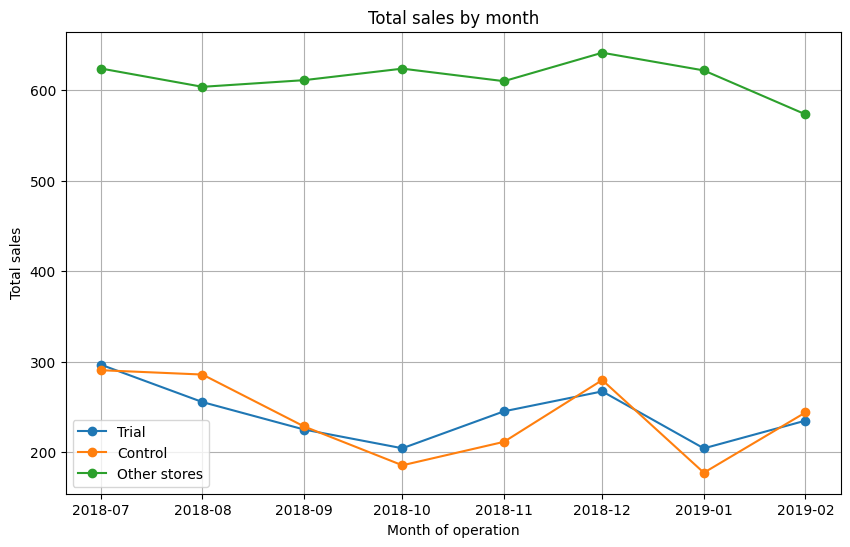

In [21]:
# Assuming 'measureOverTimeSales' is the equivalent DataFrame in Python
measureOverTimeSales = measureOverTime.copy()

# Create a 'Store_type' column
measureOverTimeSales['Store_type'] = np.where(measureOverTimeSales['STORE_NBR'] == trial_store, 'Trial',
                                             np.where(measureOverTimeSales['STORE_NBR'] == control_store, 'Control', 'Other stores'))

# Calculate the mean of total sales by year and month for each store type
pastSales = measureOverTimeSales.groupby(['YEARMONTH', 'Store_type'])['totSales'].mean().reset_index()

# Convert MONTH_ID to a datetime format
pastSales['TransactionMonth'] = pd.to_datetime(pastSales['YEARMONTH'], format='%Y%m')

# Filter data for months before March 2019
pastSales = pastSales[pastSales['YEARMONTH'] < 201903]

# Create separate DataFrames for each store type
trial_sales = pastSales[pastSales['Store_type'] == 'Trial']
control_sales = pastSales[pastSales['Store_type'] == 'Control']
other_sales = pastSales[pastSales['Store_type'] == 'Other stores']

# Plot the data using Matplotlib
plt.figure(figsize=(10, 6))

# Plot total sales for the trial store
plt.plot(trial_sales['TransactionMonth'], trial_sales['totSales'], label='Trial', marker='o')

# Plot total sales for the control store
plt.plot(control_sales['TransactionMonth'], control_sales['totSales'], label='Control', marker='o')

# Plot total sales for other stores
plt.plot(other_sales['TransactionMonth'], other_sales['totSales'], label='Other stores', marker='o')

plt.xlabel("Month of operation")
plt.ylabel("Total sales")
plt.title("Total sales by month")
plt.legend()
plt.grid(True)
plt.show()

Next, number of customers.


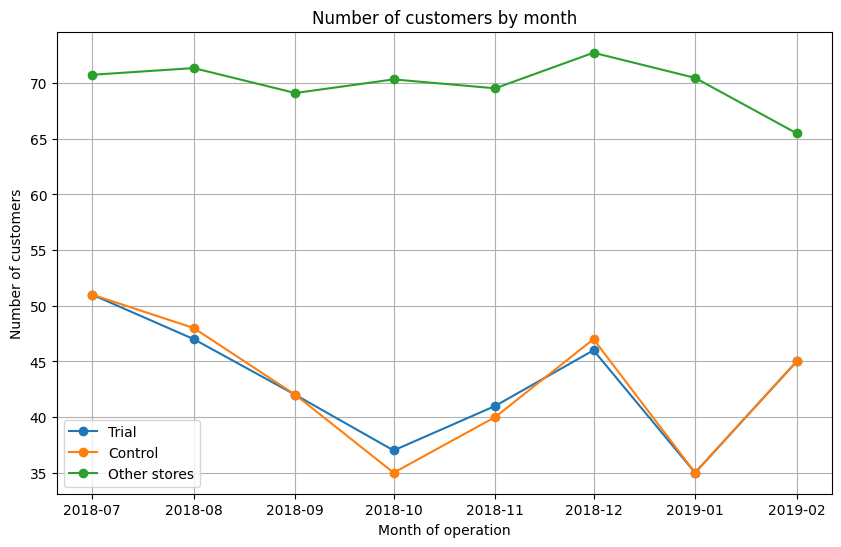

In [20]:
# Assuming 'measureOverTimeCusts' is the equivalent DataFrame in Python
measureOverTimeCusts = measureOverTime.copy()

# Create a 'Store_type' column
measureOverTimeCusts['Store_type'] = 'Other stores'
measureOverTimeCusts.loc[measureOverTimeCusts['STORE_NBR'] == trial_store, 'Store_type'] = 'Trial'
measureOverTimeCusts.loc[measureOverTimeCusts['STORE_NBR'] == control_store, 'Store_type'] = 'Control'

# Calculate the mean of the number of customers by year and month for each store type
pastCustomers = measureOverTimeCusts.groupby(['YEARMONTH', 'Store_type'])['nCustomers'].mean().reset_index()

# Convert MONTH_ID to a datetime format
pastCustomers['TransactionMonth'] = pd.to_datetime(pastCustomers['YEARMONTH'], format='%Y%m')

# Filter data for months before March 2019
pastCustomers = pastCustomers[pastCustomers['YEARMONTH'] < 201903]

# Create separate DataFrames for each store type
trial_customers = pastCustomers[pastCustomers['Store_type'] == 'Trial']
control_customers = pastCustomers[pastCustomers['Store_type'] == 'Control']
other_customers = pastCustomers[pastCustomers['Store_type'] == 'Other stores']

# Plot the data using Matplotlib
plt.figure(figsize=(10, 6))

# Plot customer count for the trial store
plt.plot(trial_customers['TransactionMonth'], trial_customers['nCustomers'], label='Trial', marker='o')

# Plot customer count for the control store
plt.plot(control_customers['TransactionMonth'], control_customers['nCustomers'], label='Control', marker='o')

# Plot customer count for other stores
plt.plot(other_customers['TransactionMonth'], other_customers['nCustomers'], label='Other stores', marker='o')

plt.xlabel("Month of operation")
plt.ylabel("Number of customers")
plt.title("Number of customers by month")
plt.legend()
plt.grid(True)
plt.show()

Assessment of trial  
The trial period goes from the start of February 2019 to April 2019. We now want to
see if there has been an uplift in overall chip sales.  
We'll start with scaling the control store's sales to a level similar to control
for any differences between the two stores outside of the trial period.

In [22]:
# Define the pre-trial months (all months before February 2019)
pre_trial_months = measureOverTime['YEARMONTH'].unique()
pre_trial_months = pre_trial_months[pre_trial_months < 201902]

# Filter data for the trial and control stores during the pre-trial period
pre_trial_data = measureOverTime[measureOverTime['STORE_NBR'].isin([trial_store, control_store])]
pre_trial_data = pre_trial_data[pre_trial_data['YEARMONTH'].isin(pre_trial_months)]

# Calculate average sales for the trial and control stores during the pre-trial period
trial_store_avg_sales = pre_trial_data[pre_trial_data['STORE_NBR'] == trial_store]['totSales'].sum()
control_store_avg_sales = pre_trial_data[pre_trial_data['STORE_NBR'] == control_store]['totSales'].sum()

# Calculate the scaling factor
scaling_factor = trial_store_avg_sales / control_store_avg_sales

# Apply the scaling factor to control store sales for the entire observation period
measureOverTime['scaled_total_sales'] = measureOverTime.apply(
    lambda row: row['totSales'] * scaling_factor if row['STORE_NBR'] == control_store else row['totSales'],
    axis=1
)

In [23]:
measureOverTime

,STORE_NBR,YEARMONTH,totSales,nCustomers,nTxnPerCust,nChipsPerTxn,avgPricePerUnit,scaled_total_sales
0,1,201807,206.9,49,1.061224,1.192308,3.337097,206.9
1,1,201808,176.1,42,1.023810,1.255814,3.261111,176.1
2,1,201809,278.8,59,1.050847,1.209677,3.717333,278.8
3,1,201810,188.1,44,1.022727,1.288889,3.243103,188.1
4,1,201811,192.6,46,1.021739,1.212766,3.378947,192.6
...,...,...,...,...,...,...,...,...
3164,272,201902,395.5,45,1.066667,1.895833,4.346154,395.5
3165,272,201903,442.3,50,1.060000,1.905660,4.379208,442.3
3166,272,201904,445.1,54,1.037037,1.875000,4.239048,445.1
3167,272,201905,314.6,34,1.176471,1.775000,4.430986,314.6


Now that we have comparable sales figures for the control store, we can calculate
the percentage difference between the scaled control sales and the trial store's
sales during the trial period.

In [24]:
# Define the trial period months (February 2019 to April 2019)
trial_period_months = [201902, 201903, 201904]

# Filter data for the trial period
trial_period_data = measureOverTime[measureOverTime['YEARMONTH'].isin(trial_period_months)]

# Calculate total sales for the trial store during the trial period
trial_store_sales_trial_period = trial_period_data[trial_period_data['STORE_NBR'] == trial_store]['totSales'].sum()

# Calculate total sales for the scaled control store during the trial period
scaled_control_store_sales_trial_period = trial_period_data[trial_period_data['STORE_NBR'] == control_store]['scaled_total_sales'].sum()

# Calculate the percentage difference
percentage_difference = ((trial_store_sales_trial_period - scaled_control_store_sales_trial_period) / trial_store_sales_trial_period) * 100

print("Percentage Difference:", percentage_difference)


Percentage Difference: 20.73223534242933


Let's see if the difference is significant  
As our null hypothesis is that the trial period is the same as the pre-trial
period, let's take the standard deviation based on the scaled percentage difference
in the pre-trial period 

In [25]:
# Define the pre-trial months 
pre_trial_months = measureOverTime['YEARMONTH'].unique()
pre_trial_months = pre_trial_months[pre_trial_months < 201902]

# Filter data for the pre-trial period
pre_trial_data = measureOverTime[measureOverTime['YEARMONTH'].isin(pre_trial_months)]

# Calculate the percentage difference between trial store and scaled control store sales for each pre-trial month
percentage_differences_pre_trial = []

for month in pre_trial_months:
    # Filter data for the specific pre-trial month
    pre_trial_month_data = pre_trial_data[pre_trial_data['YEARMONTH'] == month]
    
    # Calculate total sales for the trial store for the specific month
    trial_store_sales_month = pre_trial_month_data[pre_trial_month_data['STORE_NBR'] == trial_store]['totSales'].values[0]
    
    # Calculate total sales for the scaled control store for the specific month
    scaled_control_store_sales_month = pre_trial_month_data[pre_trial_month_data['STORE_NBR'] == control_store]['scaled_total_sales'].values[0]
    
    # Calculate the percentage difference for the specific month
    percentage_diff_month = ((trial_store_sales_month - scaled_control_store_sales_month) / trial_store_sales_month) * 100
    
    # Append the percentage difference to the list
    percentage_differences_pre_trial.append(percentage_diff_month)

# Calculate the standard deviation of the pre-trial percentage differences
std_dev_pre_trial = np.std(percentage_differences_pre_trial)

print("Standard Deviation based on Pre-Trial Percentage Differences:", std_dev_pre_trial)

Standard Deviation based on Pre-Trial Percentage Differences: 9.146437776560084


In [26]:
from scipy.stats import t

# Degrees of freedom
degrees_of_freedom = 7

# Define the significance level (alpha) for a two-tailed test
alpha = 0.05

# Calculate the critical t-value for a two-tailed test
critical_t_value = t.ppf(1 - alpha / 2, df=degrees_of_freedom)

# Initialize an empty list to store t-values for each trial month
t_values_trial_months = []

# Calculate the t-value for each trial month
for month in trial_period_months:
    # Filter data for the specific trial month
    trial_month_data = trial_period_data[trial_period_data['YEARMONTH'] == month]
    
    # Calculate total sales for the trial store for the specific month
    trial_store_sales_month = trial_month_data[trial_month_data['STORE_NBR'] == trial_store]['totSales'].values[0]
    
    # Calculate total sales for the scaled control store for the specific month
    scaled_control_store_sales_month = trial_month_data[trial_month_data['STORE_NBR'] == control_store]['scaled_total_sales'].values[0]
    
    # Calculate the percentage difference for the specific month
    percentage_diff_month = ((trial_store_sales_month - scaled_control_store_sales_month) / trial_store_sales_month) * 100
    
    # Calculate the standard error of the mean for the pre-trial period
    sem_pre_trial = std_dev_pre_trial / np.sqrt(8)  # 8 is the number of pre-trial months
    
    # Calculate the t-value for the specific month
    t_value_month = percentage_diff_month / sem_pre_trial
    
    # Append the t-value to the list
    t_values_trial_months.append(t_value_month)

# Find the 95th percentile of the t-distribution
critical_t_value = t.ppf(1 - alpha / 2, df=degrees_of_freedom)

# Print the critical t-value and t-values for the trial months
print("Critical t-Value (95th Percentile):", critical_t_value)
print("T-Values for Trial Months:", t_values_trial_months)

Critical t-Value (95th Percentile): 2.3646242510102993
T-Values for Trial Months: [-1.9426235388242967, 8.294220778288164, 11.871257361715779]


We can observe that the t-value is much larger than the 95th percentile value of
the t-distribution for March and April - i.e. the increase in sales in the trial
store in March and April is statistically greater than in the control store.

In [27]:
# Define the trial period months (February 2019 to April 2019)
trial_period_months = [201902, 201903, 201904]

# Filter data for the trial period
trial_period_data = measureOverTimeSales[measureOverTimeSales['YEARMONTH'].isin(trial_period_months)]

# Filter the DataFrame to include only rows where 'str_type' is 'control'
control_sales = trial_period_data[trial_period_data['Store_type'] == 'Control']['totSales']

# Calculate the 95th and 5th percentiles using the quantile function
percentile_95 = control_sales.quantile(0.95)
percentile_5 = control_sales.quantile(0.05)

print(f"95th Percentile for Control Sales: {percentile_95}")
print(f"5th Percentile for Control Sales: {percentile_5}")


95th Percentile for Control Sales: 239.51
5th Percentile for Control Sales: 162.65


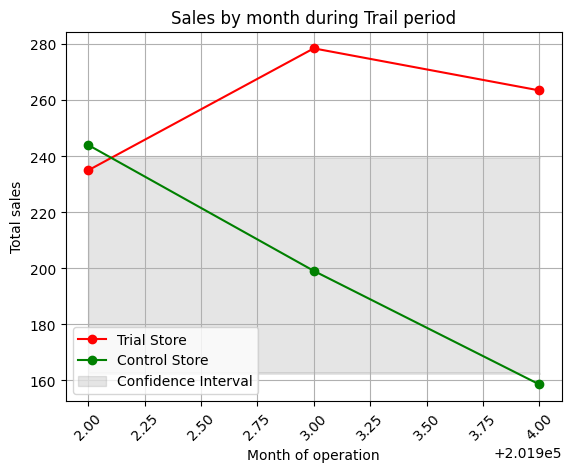

In [28]:
X = trial_period_data[trial_period_data['Store_type'] == 'Trial']
Y = trial_period_data[trial_period_data['Store_type'] == 'Control']


plt.plot(X['YEARMONTH'], X['totSales'], label='Trial Store', marker='o', color='red')
plt.plot(Y['YEARMONTH'], Y['totSales'], label='Control Store', marker='o', color='green')

plt.fill_between(trial_period_data['YEARMONTH'], percentile_5, percentile_95, color='gray', alpha=0.2, label='Confidence Interval')

# Customize labels and title
plt.xlabel("Month of operation")
plt.ylabel("Total sales")
plt.title("Sales by month during Trail period")
plt.legend()

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

The results show that the trial in store 77 is significantly different to its
control store in the trial period as the trial store performance lies outside the
5% to 95% confidence interval of the control store in two of the three trial
months.


Let's have a look at assessing this for number of customers as well.
This would be a repeat of the steps before for total sales


Percentage Difference: 18.742319689951795
Standard Deviation based on Pre-Trial Percentage Differences: 2.475985465835357
Critical t-Value (95th Percentile): 2.3646242510102993
T-Values for Trial Months: [-0.3833369105509496, 22.54021034039504, 41.074142160308796]
95th Percentile for Control Sales: 44.5
5th Percentile for Control Sales: 31.0


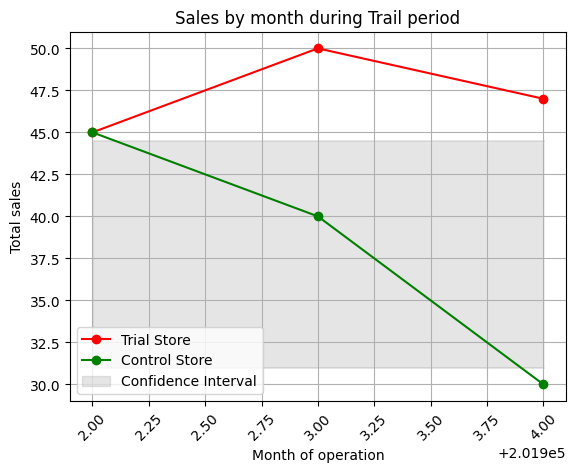

In [33]:
# Define the pre-trial months (all months before February 2019)
pre_trial_months = measureOverTime['YEARMONTH'].unique()
pre_trial_months = pre_trial_months[pre_trial_months < 201902]

# Filter data for the trial and control stores during the pre-trial period
pre_trial_data = measureOverTime[measureOverTime['STORE_NBR'].isin([trial_store, control_store])]
pre_trial_data = pre_trial_data[pre_trial_data['YEARMONTH'].isin(pre_trial_months)]

# Calculate average sales for the trial and control stores during the pre-trial period
trial_store_avg_sales = pre_trial_data[pre_trial_data['STORE_NBR'] == trial_store]['nCustomers'].sum()
control_store_avg_sales = pre_trial_data[pre_trial_data['STORE_NBR'] == control_store]['nCustomers'].sum()

# Calculate the scaling factor
scaling_factor = trial_store_avg_sales / control_store_avg_sales

# Apply the scaling factor to control store sales for the entire observation period
measureOverTime['scaled_number_of_customers'] = measureOverTime.apply(
    lambda row: row['nCustomers'] * scaling_factor if row['STORE_NBR'] == control_store else row['nCustomers'],
    axis=1
)

# Define the trial period months (February 2019 to April 2019)
trial_period_months = [201902, 201903, 201904]

# Filter data for the trial period
trial_period_data = measureOverTime[measureOverTime['YEARMONTH'].isin(trial_period_months)]

# Calculate total sales for the trial store during the trial period
trial_store_sales_trial_period = trial_period_data[trial_period_data['STORE_NBR'] == trial_store]['nCustomers'].sum()

# Calculate total sales for the scaled control store during the trial period
scaled_control_store_sales_trial_period = trial_period_data[trial_period_data['STORE_NBR'] == control_store]['scaled_number_of_customers'].sum()

# Calculate the percentage difference
percentage_difference = ((trial_store_sales_trial_period - scaled_control_store_sales_trial_period) / trial_store_sales_trial_period) * 100

print("Percentage Difference:", percentage_difference)

# Define the pre-trial months 
pre_trial_months = measureOverTime['YEARMONTH'].unique()
pre_trial_months = pre_trial_months[pre_trial_months < 201902]

# Filter data for the pre-trial period
pre_trial_data = measureOverTime[measureOverTime['YEARMONTH'].isin(pre_trial_months)]

# Calculate the percentage difference between trial store and scaled control store sales for each pre-trial month
percentage_differences_pre_trial = []

for month in pre_trial_months:
    # Filter data for the specific pre-trial month
    pre_trial_month_data = pre_trial_data[pre_trial_data['YEARMONTH'] == month]
    
    # Calculate total sales for the trial store for the specific month
    trial_store_sales_month = pre_trial_month_data[pre_trial_month_data['STORE_NBR'] == trial_store]['nCustomers'].values[0]
    
    # Calculate total sales for the scaled control store for the specific month
    scaled_control_store_sales_month = pre_trial_month_data[pre_trial_month_data['STORE_NBR'] == control_store]['scaled_number_of_customers'].values[0]
    
    # Calculate the percentage difference for the specific month
    percentage_diff_month = ((trial_store_sales_month - scaled_control_store_sales_month) / trial_store_sales_month) * 100
    
    # Append the percentage difference to the list
    percentage_differences_pre_trial.append(percentage_diff_month)

# Calculate the standard deviation of the pre-trial percentage differences
std_dev_pre_trial = np.std(percentage_differences_pre_trial)

print("Standard Deviation based on Pre-Trial Percentage Differences:", std_dev_pre_trial)

from scipy.stats import t

# Degrees of freedom
degrees_of_freedom = 7

# Define the significance level (alpha) for a two-tailed test
alpha = 0.05

# Calculate the critical t-value for a two-tailed test
critical_t_value = t.ppf(1 - alpha / 2, df=degrees_of_freedom)

# Initialize an empty list to store t-values for each trial month
t_values_trial_months = []

# Calculate the t-value for each trial month
for month in trial_period_months:
    # Filter data for the specific trial month
    trial_month_data = trial_period_data[trial_period_data['YEARMONTH'] == month]
    
    # Calculate total sales for the trial store for the specific month
    trial_store_sales_month = trial_month_data[trial_month_data['STORE_NBR'] == trial_store]['nCustomers'].values[0]
    
    # Calculate total sales for the scaled control store for the specific month
    scaled_control_store_sales_month = trial_month_data[trial_month_data['STORE_NBR'] == control_store]['scaled_number_of_customers'].values[0]
    
    # Calculate the percentage difference for the specific month
    percentage_diff_month = ((trial_store_sales_month - scaled_control_store_sales_month) / trial_store_sales_month) * 100
    
    # Calculate the standard error of the mean for the pre-trial period
    sem_pre_trial = std_dev_pre_trial / np.sqrt(8)  # 8 is the number of pre-trial months
    
    # Calculate the t-value for the specific month
    t_value_month = percentage_diff_month / sem_pre_trial
    
    # Append the t-value to the list
    t_values_trial_months.append(t_value_month)

# Find the 95th percentile of the t-distribution
critical_t_value = t.ppf(1 - alpha / 2, df=degrees_of_freedom)

# Print the critical t-value and t-values for the trial months
print("Critical t-Value (95th Percentile):", critical_t_value)
print("T-Values for Trial Months:", t_values_trial_months)

# Define the trial period months (February 2019 to April 2019)
trial_period_months = [201902, 201903, 201904]

# Filter data for the trial period
trial_period_data = measureOverTimeSales[measureOverTimeSales['YEARMONTH'].isin(trial_period_months)]

# Filter the DataFrame to include only rows where 'str_type' is 'control'
control_sales = trial_period_data[trial_period_data['Store_type'] == 'Control']['nCustomers']

# Calculate the 95th and 5th percentiles using the quantile function
percentile_95 = control_sales.quantile(0.95)
percentile_5 = control_sales.quantile(0.05)

print(f"95th Percentile for Control Sales: {percentile_95}")
print(f"5th Percentile for Control Sales: {percentile_5}")

X = trial_period_data[trial_period_data['Store_type'] == 'Trial']
Y = trial_period_data[trial_period_data['Store_type'] == 'Control']


plt.plot(X['YEARMONTH'], X['nCustomers'], label='Trial Store', marker='o', color='red')
plt.plot(Y['YEARMONTH'], Y['nCustomers'], label='Control Store', marker='o', color='green')

plt.fill_between(trial_period_data['YEARMONTH'], percentile_5, percentile_95, color='gray', alpha=0.2, label='Confidence Interval')

# Customize labels and title
plt.xlabel("Month of operation")
plt.ylabel("Total sales")
plt.title("Sales by month during Trail period")
plt.legend()

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

Let's repeat finding the control store and assessing the impact of the trial for
each of the other two trial stores. 

TRIAL STORE - 86

Selected Control Store: 155
Percentage Difference: 11.621853192858737
Standard Deviation based on Pre-Trial Percentage Differences: 3.5905237774875434
Critical t-Value (95th Percentile): 2.3646242510102993
T-Values for Trial Months: [4.199073480570273, 18.909598068530862, 2.6824451847427775]
95th Percentile for Control Sales: 886.5400000000001
5th Percentile for Control Sales: 808.42


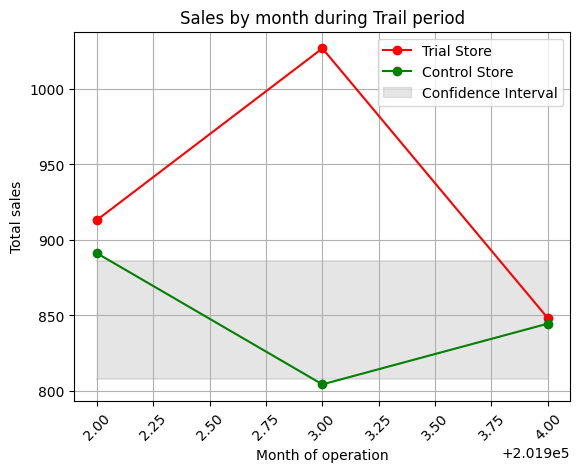

In [35]:
# Define the trial store
trial_store = 86

# Calculate correlations for total sales and number of customers
corr_nSales = calculateCorrelation(pre_trail_data, 'totSales', trial_store)
corr_nCustomers = calculateCorrelation(pre_trail_data, 'nCustomers', trial_store)

# Calculate magnitude distances for total sales and number of customers
magnitude_nSales = calculate_magnitude_distance(pre_trail_data, 'totSales', trial_store)
magnitude_nCustomers = calculate_magnitude_distance(pre_trail_data, 'nCustomers', trial_store)

# Calculate the combined score for total sales
score_nSales = pd.merge(corr_nSales, magnitude_nSales, on=['Store1', 'Store2'], how='inner')
score_nSales['scoreNSales'] = 0.5 * score_nSales['corr_measure'] + 0.5 * score_nSales['mag_measure']

# Calculate the combined score for number of customers
score_nCustomers = pd.merge(corr_nCustomers, magnitude_nCustomers, on=['Store1', 'Store2'], how='inner')
score_nCustomers['scoreNCust'] = 0.5 * score_nCustomers['corr_measure'] + 0.5 * score_nCustomers['mag_measure']

# Merge sales scores and customer scores into a single table
score_Control = pd.merge(score_nSales[['Store1', 'Store2', 'scoreNSales']], score_nCustomers[['Store1', 'Store2', 'scoreNCust']], on=['Store1', 'Store2'], how='inner')

# Calculate the final control score as the weighted average of sales and customer scores
score_Control['finalControlScore'] = 0.5 * score_Control['scoreNSales'] + 0.5 * score_Control['scoreNCust']

# Select the control store with the highest final score (closest to 1 but not the trial store itself)
control_store = score_Control[score_Control['Store1'] == trial_store].sort_values(by='finalControlScore', ascending=False)['Store2'].values[0]

# Print the selected control store
print("Selected Control Store:", control_store)

# Assuming 'measureOverTimeSales' is the equivalent DataFrame in Python
measureOverTimeSales = measureOverTime.copy()

# Create a 'Store_type' column
measureOverTimeSales['Store_type'] = np.where(measureOverTimeSales['STORE_NBR'] == trial_store, 'Trial',
                                             np.where(measureOverTimeSales['STORE_NBR'] == control_store, 'Control', 'Other stores'))

# Calculate the mean of total sales by year and month for each store type
pastSales = measureOverTimeSales.groupby(['YEARMONTH', 'Store_type'])['totSales'].mean().reset_index()

# Convert MONTH_ID to a datetime format
pastSales['TransactionMonth'] = pd.to_datetime(pastSales['YEARMONTH'], format='%Y%m')

# Filter data for months before March 2019
pastSales = pastSales[pastSales['YEARMONTH'] < 201903]

# Assuming 'measureOverTimeCusts' is the equivalent DataFrame in Python
measureOverTimeCusts = measureOverTime.copy()

# Create a 'Store_type' column
measureOverTimeCusts['Store_type'] = 'Other stores'
measureOverTimeCusts.loc[measureOverTimeCusts['STORE_NBR'] == trial_store, 'Store_type'] = 'Trial'
measureOverTimeCusts.loc[measureOverTimeCusts['STORE_NBR'] == control_store, 'Store_type'] = 'Control'

# Calculate the mean of the number of customers by year and month for each store type
pastCustomers = measureOverTimeCusts.groupby(['YEARMONTH', 'Store_type'])['nCustomers'].mean().reset_index()

# Convert MONTH_ID to a datetime format
pastCustomers['TransactionMonth'] = pd.to_datetime(pastCustomers['YEARMONTH'], format='%Y%m')

# Filter data for months before March 2019
pastCustomers = pastCustomers[pastCustomers['YEARMONTH'] < 201903]

# Define the pre-trial months (all months before February 2019)
pre_trial_months = measureOverTime['YEARMONTH'].unique()
pre_trial_months = pre_trial_months[pre_trial_months < 201902]

# Filter data for the trial and control stores during the pre-trial period
pre_trial_data = measureOverTime[measureOverTime['STORE_NBR'].isin([trial_store, control_store])]
pre_trial_data = pre_trial_data[pre_trial_data['YEARMONTH'].isin(pre_trial_months)]

# Calculate average sales for the trial and control stores during the pre-trial period
trial_store_avg_sales = pre_trial_data[pre_trial_data['STORE_NBR'] == trial_store]['totSales'].sum()
control_store_avg_sales = pre_trial_data[pre_trial_data['STORE_NBR'] == control_store]['totSales'].sum()

# Calculate the scaling factor
scaling_factor = trial_store_avg_sales / control_store_avg_sales

# Apply the scaling factor to control store sales for the entire observation period
measureOverTime['scaled_total_sales'] = measureOverTime.apply(
    lambda row: row['totSales'] * scaling_factor if row['STORE_NBR'] == control_store else row['totSales'],
    axis=1
)

# Define the trial period months (February 2019 to April 2019)
trial_period_months = [201902, 201903, 201904]

# Filter data for the trial period
trial_period_data = measureOverTime[measureOverTime['YEARMONTH'].isin(trial_period_months)]

# Calculate total sales for the trial store during the trial period
trial_store_sales_trial_period = trial_period_data[trial_period_data['STORE_NBR'] == trial_store]['totSales'].sum()

# Calculate total sales for the scaled control store during the trial period
scaled_control_store_sales_trial_period = trial_period_data[trial_period_data['STORE_NBR'] == control_store]['scaled_total_sales'].sum()

# Calculate the percentage difference
percentage_difference = ((trial_store_sales_trial_period - scaled_control_store_sales_trial_period) / trial_store_sales_trial_period) * 100

print("Percentage Difference:", percentage_difference)

# Define the pre-trial months 
pre_trial_months = measureOverTime['YEARMONTH'].unique()
pre_trial_months = pre_trial_months[pre_trial_months < 201902]

# Filter data for the pre-trial period
pre_trial_data = measureOverTime[measureOverTime['YEARMONTH'].isin(pre_trial_months)]

# Calculate the percentage difference between trial store and scaled control store sales for each pre-trial month
percentage_differences_pre_trial = []

for month in pre_trial_months:
    # Filter data for the specific pre-trial month
    pre_trial_month_data = pre_trial_data[pre_trial_data['YEARMONTH'] == month]
    
    # Calculate total sales for the trial store for the specific month
    trial_store_sales_month = pre_trial_month_data[pre_trial_month_data['STORE_NBR'] == trial_store]['totSales'].values[0]
    
    # Calculate total sales for the scaled control store for the specific month
    scaled_control_store_sales_month = pre_trial_month_data[pre_trial_month_data['STORE_NBR'] == control_store]['scaled_total_sales'].values[0]
    
    # Calculate the percentage difference for the specific month
    percentage_diff_month = ((trial_store_sales_month - scaled_control_store_sales_month) / trial_store_sales_month) * 100
    
    # Append the percentage difference to the list
    percentage_differences_pre_trial.append(percentage_diff_month)

# Calculate the standard deviation of the pre-trial percentage differences
std_dev_pre_trial = np.std(percentage_differences_pre_trial)

print("Standard Deviation based on Pre-Trial Percentage Differences:", std_dev_pre_trial)

from scipy.stats import t

# Degrees of freedom
degrees_of_freedom = 7

# Define the significance level (alpha) for a two-tailed test
alpha = 0.05

# Calculate the critical t-value for a two-tailed test
critical_t_value = t.ppf(1 - alpha / 2, df=degrees_of_freedom)

# Initialize an empty list to store t-values for each trial month
t_values_trial_months = []

# Calculate the t-value for each trial month
for month in trial_period_months:
    # Filter data for the specific trial month
    trial_month_data = trial_period_data[trial_period_data['YEARMONTH'] == month]
    
    # Calculate total sales for the trial store for the specific month
    trial_store_sales_month = trial_month_data[trial_month_data['STORE_NBR'] == trial_store]['totSales'].values[0]
    
    # Calculate total sales for the scaled control store for the specific month
    scaled_control_store_sales_month = trial_month_data[trial_month_data['STORE_NBR'] == control_store]['scaled_total_sales'].values[0]
    
    # Calculate the percentage difference for the specific month
    percentage_diff_month = ((trial_store_sales_month - scaled_control_store_sales_month) / trial_store_sales_month) * 100
    
    # Calculate the standard error of the mean for the pre-trial period
    sem_pre_trial = std_dev_pre_trial / np.sqrt(8)  # 8 is the number of pre-trial months
    
    # Calculate the t-value for the specific month
    t_value_month = percentage_diff_month / sem_pre_trial
    
    # Append the t-value to the list
    t_values_trial_months.append(t_value_month)

# Find the 95th percentile of the t-distribution
critical_t_value = t.ppf(1 - alpha / 2, df=degrees_of_freedom)

# Print the critical t-value and t-values for the trial months
print("Critical t-Value (95th Percentile):", critical_t_value)
print("T-Values for Trial Months:", t_values_trial_months)

# Define the trial period months (February 2019 to April 2019)
trial_period_months = [201902, 201903, 201904]

# Filter data for the trial period
trial_period_data = measureOverTimeSales[measureOverTimeSales['YEARMONTH'].isin(trial_period_months)]

# Filter the DataFrame to include only rows where 'str_type' is 'control'
control_sales = trial_period_data[trial_period_data['Store_type'] == 'Control']['totSales']

# Calculate the 95th and 5th percentiles using the quantile function
percentile_95 = control_sales.quantile(0.95)
percentile_5 = control_sales.quantile(0.05)

print(f"95th Percentile for Control Sales: {percentile_95}")
print(f"5th Percentile for Control Sales: {percentile_5}")

X = trial_period_data[trial_period_data['Store_type'] == 'Trial']
Y = trial_period_data[trial_period_data['Store_type'] == 'Control']

plt.plot(X['YEARMONTH'], X['totSales'], label='Trial Store', marker='o', color='red')
plt.plot(Y['YEARMONTH'], Y['totSales'], label='Control Store', marker='o', color='green')

plt.fill_between(trial_period_data['YEARMONTH'], percentile_5, percentile_95, color='gray', alpha=0.2, label='Confidence Interval')

# Customize labels and title
plt.xlabel("Month of operation")
plt.ylabel("Total sales")
plt.title("Sales by month during Trail period")
plt.legend()

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

The results show that the trial in store 86 is significantly different to its
control store in the trial period as the trial store performance lies outside the
5% to 95% confidence interval of the control store in two of the three trial
months.

next, number of customers

Percentage Difference: 11.926605504587156
Standard Deviation based on Pre-Trial Percentage Differences: 1.7597329163924977
Critical t-Value (95th Percentile): 2.3646242510102993
T-Values for Trial Months: [18.025847979001835, 29.350782904939948, 9.18459873215808]
95th Percentile for Control Sales: 98.6
5th Percentile for Control Sales: 94.1


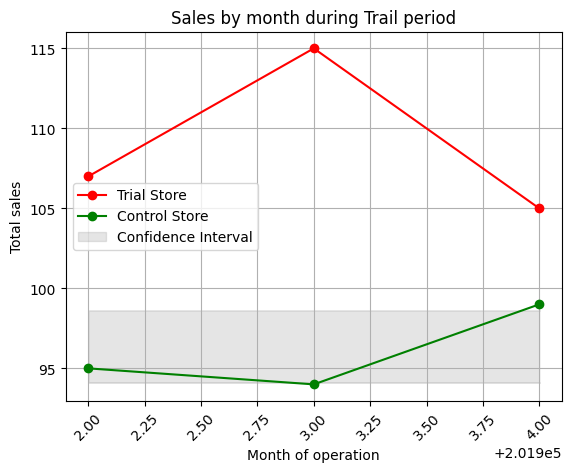

In [36]:
# Define the pre-trial months (all months before February 2019)
pre_trial_months = measureOverTime['YEARMONTH'].unique()
pre_trial_months = pre_trial_months[pre_trial_months < 201902]

# Filter data for the trial and control stores during the pre-trial period
pre_trial_data = measureOverTime[measureOverTime['STORE_NBR'].isin([trial_store, control_store])]
pre_trial_data = pre_trial_data[pre_trial_data['YEARMONTH'].isin(pre_trial_months)]

# Calculate average sales for the trial and control stores during the pre-trial period
trial_store_avg_sales = pre_trial_data[pre_trial_data['STORE_NBR'] == trial_store]['nCustomers'].sum()
control_store_avg_sales = pre_trial_data[pre_trial_data['STORE_NBR'] == control_store]['nCustomers'].sum()

# Calculate the scaling factor
scaling_factor = trial_store_avg_sales / control_store_avg_sales

# Apply the scaling factor to control store sales for the entire observation period
measureOverTime['scaled_number_of_customers'] = measureOverTime.apply(
    lambda row: row['nCustomers'] * scaling_factor if row['STORE_NBR'] == control_store else row['nCustomers'],
    axis=1
)

# Define the trial period months (February 2019 to April 2019)
trial_period_months = [201902, 201903, 201904]

# Filter data for the trial period
trial_period_data = measureOverTime[measureOverTime['YEARMONTH'].isin(trial_period_months)]

# Calculate total sales for the trial store during the trial period
trial_store_sales_trial_period = trial_period_data[trial_period_data['STORE_NBR'] == trial_store]['nCustomers'].sum()

# Calculate total sales for the scaled control store during the trial period
scaled_control_store_sales_trial_period = trial_period_data[trial_period_data['STORE_NBR'] == control_store]['scaled_number_of_customers'].sum()

# Calculate the percentage difference
percentage_difference = ((trial_store_sales_trial_period - scaled_control_store_sales_trial_period) / trial_store_sales_trial_period) * 100

print("Percentage Difference:", percentage_difference)

# Define the pre-trial months 
pre_trial_months = measureOverTime['YEARMONTH'].unique()
pre_trial_months = pre_trial_months[pre_trial_months < 201902]

# Filter data for the pre-trial period
pre_trial_data = measureOverTime[measureOverTime['YEARMONTH'].isin(pre_trial_months)]

# Calculate the percentage difference between trial store and scaled control store sales for each pre-trial month
percentage_differences_pre_trial = []

for month in pre_trial_months:
    # Filter data for the specific pre-trial month
    pre_trial_month_data = pre_trial_data[pre_trial_data['YEARMONTH'] == month]
    
    # Calculate total sales for the trial store for the specific month
    trial_store_sales_month = pre_trial_month_data[pre_trial_month_data['STORE_NBR'] == trial_store]['nCustomers'].values[0]
    
    # Calculate total sales for the scaled control store for the specific month
    scaled_control_store_sales_month = pre_trial_month_data[pre_trial_month_data['STORE_NBR'] == control_store]['scaled_number_of_customers'].values[0]
    
    # Calculate the percentage difference for the specific month
    percentage_diff_month = ((trial_store_sales_month - scaled_control_store_sales_month) / trial_store_sales_month) * 100
    
    # Append the percentage difference to the list
    percentage_differences_pre_trial.append(percentage_diff_month)

# Calculate the standard deviation of the pre-trial percentage differences
std_dev_pre_trial = np.std(percentage_differences_pre_trial)

print("Standard Deviation based on Pre-Trial Percentage Differences:", std_dev_pre_trial)

from scipy.stats import t

# Degrees of freedom
degrees_of_freedom = 7

# Define the significance level (alpha) for a two-tailed test
alpha = 0.05

# Calculate the critical t-value for a two-tailed test
critical_t_value = t.ppf(1 - alpha / 2, df=degrees_of_freedom)

# Initialize an empty list to store t-values for each trial month
t_values_trial_months = []

# Calculate the t-value for each trial month
for month in trial_period_months:
    # Filter data for the specific trial month
    trial_month_data = trial_period_data[trial_period_data['YEARMONTH'] == month]
    
    # Calculate total sales for the trial store for the specific month
    trial_store_sales_month = trial_month_data[trial_month_data['STORE_NBR'] == trial_store]['nCustomers'].values[0]
    
    # Calculate total sales for the scaled control store for the specific month
    scaled_control_store_sales_month = trial_month_data[trial_month_data['STORE_NBR'] == control_store]['scaled_number_of_customers'].values[0]
    
    # Calculate the percentage difference for the specific month
    percentage_diff_month = ((trial_store_sales_month - scaled_control_store_sales_month) / trial_store_sales_month) * 100
    
    # Calculate the standard error of the mean for the pre-trial period
    sem_pre_trial = std_dev_pre_trial / np.sqrt(8)  # 8 is the number of pre-trial months
    
    # Calculate the t-value for the specific month
    t_value_month = percentage_diff_month / sem_pre_trial
    
    # Append the t-value to the list
    t_values_trial_months.append(t_value_month)

# Find the 95th percentile of the t-distribution
critical_t_value = t.ppf(1 - alpha / 2, df=degrees_of_freedom)

# Print the critical t-value and t-values for the trial months
print("Critical t-Value (95th Percentile):", critical_t_value)
print("T-Values for Trial Months:", t_values_trial_months)

# Define the trial period months (February 2019 to April 2019)
trial_period_months = [201902, 201903, 201904]

# Filter data for the trial period
trial_period_data = measureOverTimeSales[measureOverTimeSales['YEARMONTH'].isin(trial_period_months)]

# Filter the DataFrame to include only rows where 'str_type' is 'control'
control_sales = trial_period_data[trial_period_data['Store_type'] == 'Control']['nCustomers']

# Calculate the 95th and 5th percentiles using the quantile function
percentile_95 = control_sales.quantile(0.95)
percentile_5 = control_sales.quantile(0.05)

print(f"95th Percentile for Control Sales: {percentile_95}")
print(f"5th Percentile for Control Sales: {percentile_5}")

X = trial_period_data[trial_period_data['Store_type'] == 'Trial']
Y = trial_period_data[trial_period_data['Store_type'] == 'Control']


plt.plot(X['YEARMONTH'], X['nCustomers'], label='Trial Store', marker='o', color='red')
plt.plot(Y['YEARMONTH'], Y['nCustomers'], label='Control Store', marker='o', color='green')

plt.fill_between(trial_period_data['YEARMONTH'], percentile_5, percentile_95, color='gray', alpha=0.2, label='Confidence Interval')

# Customize labels and title
plt.xlabel("Month of operation")
plt.ylabel("Total sales")
plt.title("Sales by month during Trail period")
plt.legend()

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

It looks like for trail store 86, the number of customers is significantly higher in all of the three months comapre to control store sales. 

TRAIL STORE - 88

Selected Control Store: 237
Percentage Difference: 10.806450425806032
Standard Deviation based on Pre-Trial Percentage Differences: 5.462885596400995
Critical t-Value (95th Percentile): 2.3646242510102993
T-Values for Trial Months: [-1.390140175644348, 9.362363158027838, 8.378252730487228]
95th Percentile for Control Sales: 1385.1399999999999
5th Percentile for Control Sales: 1204.96


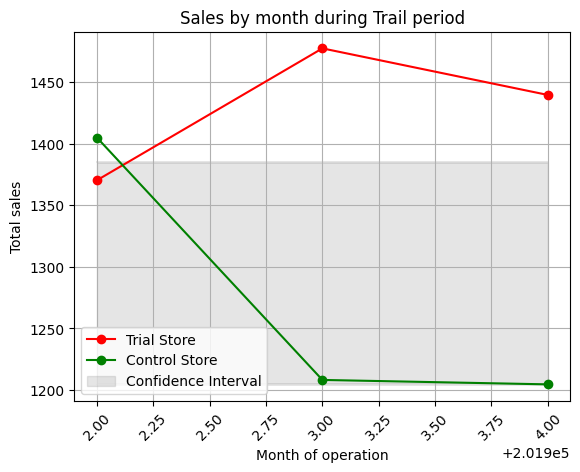

In [37]:
# Define the trial store
trial_store = 88

# Calculate correlations for total sales and number of customers
corr_nSales = calculateCorrelation(pre_trail_data, 'totSales', trial_store)
corr_nCustomers = calculateCorrelation(pre_trail_data, 'nCustomers', trial_store)

# Calculate magnitude distances for total sales and number of customers
magnitude_nSales = calculate_magnitude_distance(pre_trail_data, 'totSales', trial_store)
magnitude_nCustomers = calculate_magnitude_distance(pre_trail_data, 'nCustomers', trial_store)

# Calculate the combined score for total sales
score_nSales = pd.merge(corr_nSales, magnitude_nSales, on=['Store1', 'Store2'], how='inner')
score_nSales['scoreNSales'] = 0.5 * score_nSales['corr_measure'] + 0.5 * score_nSales['mag_measure']

# Calculate the combined score for number of customers
score_nCustomers = pd.merge(corr_nCustomers, magnitude_nCustomers, on=['Store1', 'Store2'], how='inner')
score_nCustomers['scoreNCust'] = 0.5 * score_nCustomers['corr_measure'] + 0.5 * score_nCustomers['mag_measure']

# Merge sales scores and customer scores into a single table
score_Control = pd.merge(score_nSales[['Store1', 'Store2', 'scoreNSales']], score_nCustomers[['Store1', 'Store2', 'scoreNCust']], on=['Store1', 'Store2'], how='inner')

# Calculate the final control score as the weighted average of sales and customer scores
score_Control['finalControlScore'] = 0.5 * score_Control['scoreNSales'] + 0.5 * score_Control['scoreNCust']

# Select the control store with the highest final score (closest to 1 but not the trial store itself)
control_store = score_Control[score_Control['Store1'] == trial_store].sort_values(by='finalControlScore', ascending=False)['Store2'].values[0]

# Print the selected control store
print("Selected Control Store:", control_store)

# Assuming 'measureOverTimeSales' is the equivalent DataFrame in Python
measureOverTimeSales = measureOverTime.copy()

# Create a 'Store_type' column
measureOverTimeSales['Store_type'] = np.where(measureOverTimeSales['STORE_NBR'] == trial_store, 'Trial',
                                             np.where(measureOverTimeSales['STORE_NBR'] == control_store, 'Control', 'Other stores'))

# Calculate the mean of total sales by year and month for each store type
pastSales = measureOverTimeSales.groupby(['YEARMONTH', 'Store_type'])['totSales'].mean().reset_index()

# Convert MONTH_ID to a datetime format
pastSales['TransactionMonth'] = pd.to_datetime(pastSales['YEARMONTH'], format='%Y%m')

# Filter data for months before March 2019
pastSales = pastSales[pastSales['YEARMONTH'] < 201903]

# Assuming 'measureOverTimeCusts' is the equivalent DataFrame in Python
measureOverTimeCusts = measureOverTime.copy()

# Create a 'Store_type' column
measureOverTimeCusts['Store_type'] = 'Other stores'
measureOverTimeCusts.loc[measureOverTimeCusts['STORE_NBR'] == trial_store, 'Store_type'] = 'Trial'
measureOverTimeCusts.loc[measureOverTimeCusts['STORE_NBR'] == control_store, 'Store_type'] = 'Control'

# Calculate the mean of the number of customers by year and month for each store type
pastCustomers = measureOverTimeCusts.groupby(['YEARMONTH', 'Store_type'])['nCustomers'].mean().reset_index()

# Convert MONTH_ID to a datetime format
pastCustomers['TransactionMonth'] = pd.to_datetime(pastCustomers['YEARMONTH'], format='%Y%m')

# Filter data for months before March 2019
pastCustomers = pastCustomers[pastCustomers['YEARMONTH'] < 201903]

# Define the pre-trial months (all months before February 2019)
pre_trial_months = measureOverTime['YEARMONTH'].unique()
pre_trial_months = pre_trial_months[pre_trial_months < 201902]

# Filter data for the trial and control stores during the pre-trial period
pre_trial_data = measureOverTime[measureOverTime['STORE_NBR'].isin([trial_store, control_store])]
pre_trial_data = pre_trial_data[pre_trial_data['YEARMONTH'].isin(pre_trial_months)]

# Calculate average sales for the trial and control stores during the pre-trial period
trial_store_avg_sales = pre_trial_data[pre_trial_data['STORE_NBR'] == trial_store]['totSales'].sum()
control_store_avg_sales = pre_trial_data[pre_trial_data['STORE_NBR'] == control_store]['totSales'].sum()

# Calculate the scaling factor
scaling_factor = trial_store_avg_sales / control_store_avg_sales

# Apply the scaling factor to control store sales for the entire observation period
measureOverTime['scaled_total_sales'] = measureOverTime.apply(
    lambda row: row['totSales'] * scaling_factor if row['STORE_NBR'] == control_store else row['totSales'],
    axis=1
)

# Define the trial period months (February 2019 to April 2019)
trial_period_months = [201902, 201903, 201904]

# Filter data for the trial period
trial_period_data = measureOverTime[measureOverTime['YEARMONTH'].isin(trial_period_months)]

# Calculate total sales for the trial store during the trial period
trial_store_sales_trial_period = trial_period_data[trial_period_data['STORE_NBR'] == trial_store]['totSales'].sum()

# Calculate total sales for the scaled control store during the trial period
scaled_control_store_sales_trial_period = trial_period_data[trial_period_data['STORE_NBR'] == control_store]['scaled_total_sales'].sum()

# Calculate the percentage difference
percentage_difference = ((trial_store_sales_trial_period - scaled_control_store_sales_trial_period) / trial_store_sales_trial_period) * 100

print("Percentage Difference:", percentage_difference)

# Define the pre-trial months 
pre_trial_months = measureOverTime['YEARMONTH'].unique()
pre_trial_months = pre_trial_months[pre_trial_months < 201902]

# Filter data for the pre-trial period
pre_trial_data = measureOverTime[measureOverTime['YEARMONTH'].isin(pre_trial_months)]

# Calculate the percentage difference between trial store and scaled control store sales for each pre-trial month
percentage_differences_pre_trial = []

for month in pre_trial_months:
    # Filter data for the specific pre-trial month
    pre_trial_month_data = pre_trial_data[pre_trial_data['YEARMONTH'] == month]
    
    # Calculate total sales for the trial store for the specific month
    trial_store_sales_month = pre_trial_month_data[pre_trial_month_data['STORE_NBR'] == trial_store]['totSales'].values[0]
    
    # Calculate total sales for the scaled control store for the specific month
    scaled_control_store_sales_month = pre_trial_month_data[pre_trial_month_data['STORE_NBR'] == control_store]['scaled_total_sales'].values[0]
    
    # Calculate the percentage difference for the specific month
    percentage_diff_month = ((trial_store_sales_month - scaled_control_store_sales_month) / trial_store_sales_month) * 100
    
    # Append the percentage difference to the list
    percentage_differences_pre_trial.append(percentage_diff_month)

# Calculate the standard deviation of the pre-trial percentage differences
std_dev_pre_trial = np.std(percentage_differences_pre_trial)

print("Standard Deviation based on Pre-Trial Percentage Differences:", std_dev_pre_trial)

from scipy.stats import t

# Degrees of freedom
degrees_of_freedom = 7

# Define the significance level (alpha) for a two-tailed test
alpha = 0.05

# Calculate the critical t-value for a two-tailed test
critical_t_value = t.ppf(1 - alpha / 2, df=degrees_of_freedom)

# Initialize an empty list to store t-values for each trial month
t_values_trial_months = []

# Calculate the t-value for each trial month
for month in trial_period_months:
    # Filter data for the specific trial month
    trial_month_data = trial_period_data[trial_period_data['YEARMONTH'] == month]
    
    # Calculate total sales for the trial store for the specific month
    trial_store_sales_month = trial_month_data[trial_month_data['STORE_NBR'] == trial_store]['totSales'].values[0]
    
    # Calculate total sales for the scaled control store for the specific month
    scaled_control_store_sales_month = trial_month_data[trial_month_data['STORE_NBR'] == control_store]['scaled_total_sales'].values[0]
    
    # Calculate the percentage difference for the specific month
    percentage_diff_month = ((trial_store_sales_month - scaled_control_store_sales_month) / trial_store_sales_month) * 100
    
    # Calculate the standard error of the mean for the pre-trial period
    sem_pre_trial = std_dev_pre_trial / np.sqrt(8)  # 8 is the number of pre-trial months
    
    # Calculate the t-value for the specific month
    t_value_month = percentage_diff_month / sem_pre_trial
    
    # Append the t-value to the list
    t_values_trial_months.append(t_value_month)

# Find the 95th percentile of the t-distribution
critical_t_value = t.ppf(1 - alpha / 2, df=degrees_of_freedom)

# Print the critical t-value and t-values for the trial months
print("Critical t-Value (95th Percentile):", critical_t_value)
print("T-Values for Trial Months:", t_values_trial_months)

# Define the trial period months (February 2019 to April 2019)
trial_period_months = [201902, 201903, 201904]

# Filter data for the trial period
trial_period_data = measureOverTimeSales[measureOverTimeSales['YEARMONTH'].isin(trial_period_months)]

# Filter the DataFrame to include only rows where 'str_type' is 'control'
control_sales = trial_period_data[trial_period_data['Store_type'] == 'Control']['totSales']

# Calculate the 95th and 5th percentiles using the quantile function
percentile_95 = control_sales.quantile(0.95)
percentile_5 = control_sales.quantile(0.05)

print(f"95th Percentile for Control Sales: {percentile_95}")
print(f"5th Percentile for Control Sales: {percentile_5}")

X = trial_period_data[trial_period_data['Store_type'] == 'Trial']
Y = trial_period_data[trial_period_data['Store_type'] == 'Control']

plt.plot(X['YEARMONTH'], X['totSales'], label='Trial Store', marker='o', color='red')
plt.plot(Y['YEARMONTH'], Y['totSales'], label='Control Store', marker='o', color='green')

plt.fill_between(trial_period_data['YEARMONTH'], percentile_5, percentile_95, color='gray', alpha=0.2, label='Confidence Interval')

# Customize labels and title
plt.xlabel("Month of operation")
plt.ylabel("Total sales")
plt.title("Sales by month during Trail period")
plt.legend()

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

The results show that the trial in store 88 is significantly different to its
control store in the trial period as the trial store performance lies outside of
the 5% to 95% confidence interval of the control store in two of the three trial
months.


next, number of customers

Percentage Difference: 5.974649454055786
Standard Deviation based on Pre-Trial Percentage Differences: 1.4702169946913137
Critical t-Value (95th Percentile): 2.3646242510102993
T-Values for Trial Months: [-1.9984967686310044, 22.500488494586754, 13.042821016328574]
95th Percentile for Control Sales: 125.4
5th Percentile for Control Sales: 119.1


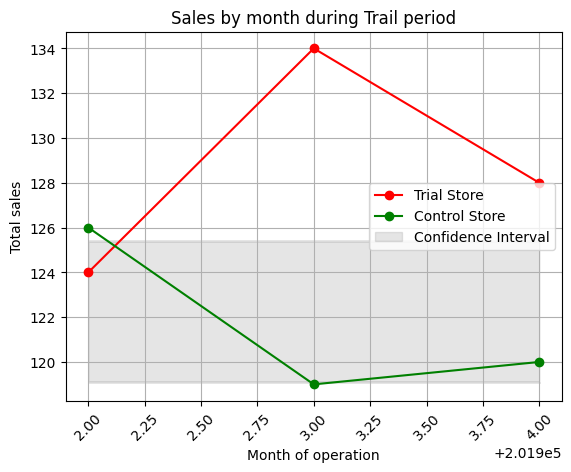

In [38]:
# Define the pre-trial months (all months before February 2019)
pre_trial_months = measureOverTime['YEARMONTH'].unique()
pre_trial_months = pre_trial_months[pre_trial_months < 201902]

# Filter data for the trial and control stores during the pre-trial period
pre_trial_data = measureOverTime[measureOverTime['STORE_NBR'].isin([trial_store, control_store])]
pre_trial_data = pre_trial_data[pre_trial_data['YEARMONTH'].isin(pre_trial_months)]

# Calculate average sales for the trial and control stores during the pre-trial period
trial_store_avg_sales = pre_trial_data[pre_trial_data['STORE_NBR'] == trial_store]['nCustomers'].sum()
control_store_avg_sales = pre_trial_data[pre_trial_data['STORE_NBR'] == control_store]['nCustomers'].sum()

# Calculate the scaling factor
scaling_factor = trial_store_avg_sales / control_store_avg_sales

# Apply the scaling factor to control store sales for the entire observation period
measureOverTime['scaled_number_of_customers'] = measureOverTime.apply(
    lambda row: row['nCustomers'] * scaling_factor if row['STORE_NBR'] == control_store else row['nCustomers'],
    axis=1
)

# Define the trial period months (February 2019 to April 2019)
trial_period_months = [201902, 201903, 201904]

# Filter data for the trial period
trial_period_data = measureOverTime[measureOverTime['YEARMONTH'].isin(trial_period_months)]

# Calculate total sales for the trial store during the trial period
trial_store_sales_trial_period = trial_period_data[trial_period_data['STORE_NBR'] == trial_store]['nCustomers'].sum()

# Calculate total sales for the scaled control store during the trial period
scaled_control_store_sales_trial_period = trial_period_data[trial_period_data['STORE_NBR'] == control_store]['scaled_number_of_customers'].sum()

# Calculate the percentage difference
percentage_difference = ((trial_store_sales_trial_period - scaled_control_store_sales_trial_period) / trial_store_sales_trial_period) * 100

print("Percentage Difference:", percentage_difference)

# Define the pre-trial months 
pre_trial_months = measureOverTime['YEARMONTH'].unique()
pre_trial_months = pre_trial_months[pre_trial_months < 201902]

# Filter data for the pre-trial period
pre_trial_data = measureOverTime[measureOverTime['YEARMONTH'].isin(pre_trial_months)]

# Calculate the percentage difference between trial store and scaled control store sales for each pre-trial month
percentage_differences_pre_trial = []

for month in pre_trial_months:
    # Filter data for the specific pre-trial month
    pre_trial_month_data = pre_trial_data[pre_trial_data['YEARMONTH'] == month]
    
    # Calculate total sales for the trial store for the specific month
    trial_store_sales_month = pre_trial_month_data[pre_trial_month_data['STORE_NBR'] == trial_store]['nCustomers'].values[0]
    
    # Calculate total sales for the scaled control store for the specific month
    scaled_control_store_sales_month = pre_trial_month_data[pre_trial_month_data['STORE_NBR'] == control_store]['scaled_number_of_customers'].values[0]
    
    # Calculate the percentage difference for the specific month
    percentage_diff_month = ((trial_store_sales_month - scaled_control_store_sales_month) / trial_store_sales_month) * 100
    
    # Append the percentage difference to the list
    percentage_differences_pre_trial.append(percentage_diff_month)

# Calculate the standard deviation of the pre-trial percentage differences
std_dev_pre_trial = np.std(percentage_differences_pre_trial)

print("Standard Deviation based on Pre-Trial Percentage Differences:", std_dev_pre_trial)

from scipy.stats import t

# Degrees of freedom
degrees_of_freedom = 7

# Define the significance level (alpha) for a two-tailed test
alpha = 0.05

# Calculate the critical t-value for a two-tailed test
critical_t_value = t.ppf(1 - alpha / 2, df=degrees_of_freedom)

# Initialize an empty list to store t-values for each trial month
t_values_trial_months = []

# Calculate the t-value for each trial month
for month in trial_period_months:
    # Filter data for the specific trial month
    trial_month_data = trial_period_data[trial_period_data['YEARMONTH'] == month]
    
    # Calculate total sales for the trial store for the specific month
    trial_store_sales_month = trial_month_data[trial_month_data['STORE_NBR'] == trial_store]['nCustomers'].values[0]
    
    # Calculate total sales for the scaled control store for the specific month
    scaled_control_store_sales_month = trial_month_data[trial_month_data['STORE_NBR'] == control_store]['scaled_number_of_customers'].values[0]
    
    # Calculate the percentage difference for the specific month
    percentage_diff_month = ((trial_store_sales_month - scaled_control_store_sales_month) / trial_store_sales_month) * 100
    
    # Calculate the standard error of the mean for the pre-trial period
    sem_pre_trial = std_dev_pre_trial / np.sqrt(8)  # 8 is the number of pre-trial months
    
    # Calculate the t-value for the specific month
    t_value_month = percentage_diff_month / sem_pre_trial
    
    # Append the t-value to the list
    t_values_trial_months.append(t_value_month)

# Find the 95th percentile of the t-distribution
critical_t_value = t.ppf(1 - alpha / 2, df=degrees_of_freedom)

# Print the critical t-value and t-values for the trial months
print("Critical t-Value (95th Percentile):", critical_t_value)
print("T-Values for Trial Months:", t_values_trial_months)

# Define the trial period months (February 2019 to April 2019)
trial_period_months = [201902, 201903, 201904]

# Filter data for the trial period
trial_period_data = measureOverTimeSales[measureOverTimeSales['YEARMONTH'].isin(trial_period_months)]

# Filter the DataFrame to include only rows where 'str_type' is 'control'
control_sales = trial_period_data[trial_period_data['Store_type'] == 'Control']['nCustomers']

# Calculate the 95th and 5th percentiles using the quantile function
percentile_95 = control_sales.quantile(0.95)
percentile_5 = control_sales.quantile(0.05)

print(f"95th Percentile for Control Sales: {percentile_95}")
print(f"5th Percentile for Control Sales: {percentile_5}")

X = trial_period_data[trial_period_data['Store_type'] == 'Trial']
Y = trial_period_data[trial_period_data['Store_type'] == 'Control']


plt.plot(X['YEARMONTH'], X['nCustomers'], label='Trial Store', marker='o', color='red')
plt.plot(Y['YEARMONTH'], Y['nCustomers'], label='Control Store', marker='o', color='green')

plt.fill_between(trial_period_data['YEARMONTH'], percentile_5, percentile_95, color='gray', alpha=0.2, label='Confidence Interval')

# Customize labels and title
plt.xlabel("Month of operation")
plt.ylabel("Total sales")
plt.title("Sales by month during Trail period")
plt.legend()

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

Total number of customers in the trial period for the trial store is significantly
higher than the control store for two out of three months, which indicates a
positive trial effect.

### Conclusion
In a three-month trial period,comparing the performance of trial stores 77, 86, and 88 with their respective control stores 233, 155, and 237.  
The results indicate that trial store 77 demonstrated sales performance outside the 5% to 95% confidence interval of the control store for two of the three trial months, while also showing a significant difference in customer count during all three months.  
 Similarly, trial store 86 exhibited sales performance outside the confidence interval for all three trial months and also displayed notable differences in customer count.  
  For trial store 88, its sales performance deviated outside the confidence interval for two of the three months, concurrent with deviations in customer count during trial period.  
   These findings suggest that the trial initiatives in stores 77 and 86 were generally successful in boosting both sales and customer engagement. However, further analysis and adjustments may be required for store 88 to optimize its performance during the trial period.